# Retirement Planner

---

## Environment Setup

In [1]:
# Import libraries and dependencies
import numpy as np
import pandas as pd
import os
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import alpaca_trade_api as tradeapi
%matplotlib inline
from tqdm  import tqdm
import time

In [2]:
# Set the random seed for resutls reproducibility (for testing purposes only)
np.random.seed(42)

---

## Portfolio Planner

In this activity, you will use the Alpaca API to grab historical data for a `60/40` portfolio using `SPY` to represent the stock portion and `AGG` to represent the bonds.

In [3]:
# Load .env enviroment variables
from dotenv import load_dotenv
load_dotenv()

# Set Alpaca API key and secret
alpaca_api_key = os.getenv("ALPACA_API_KEY")
alpaca_secret_key = os.getenv("ALPACA_SECRET_KEY")

# Create the Alpaca API object
api = tradeapi.REST(
    alpaca_api_key,
    alpaca_secret_key,
    api_version="v2")

# Data Collection

In this step, you will need to use the Alpaca api to fetch closing prices for the `SPY` and `AGG` tickers. Save the results as a pandas DataFrame

In [4]:
# Subset your tickers, then pull returns data:
# Set the ticker
ticker = ["SPY", "AGG"]

# Set timeframe to '1D'
timeframe = "1D"

# Set start and end datetimes of 1 year, between now and 365 days ago.
start_date = pd.Timestamp('2019-01-01', tz='America/New_York').isoformat()
end_date = pd.Timestamp('2019-12-31', tz='America/New_York').isoformat()

# Get 1 year's worth of historical data for SPY and AGG
df = api.get_barset(
    ticker,
    timeframe,
    limit=None,
    start=start_date,
    end=end_date,
    after=None,
    until=None,
).df

# Drop unnecessary columns
df = df.drop( columns=['open', 'high', 'low', 'volume'], level=1)

In [31]:
# Display sample data

df

,AGG,SPY
,close,close
2019-01-02 00:00:00-05:00,106.585,249.89
2019-01-03 00:00:00-05:00,107.020,244.46
2019-01-04 00:00:00-05:00,106.695,252.41
2019-01-07 00:00:00-05:00,106.470,254.40
2019-01-08 00:00:00-05:00,106.420,256.65
...,...,...
2019-12-24 00:00:00-05:00,112.375,321.26
2019-12-26 00:00:00-05:00,112.480,322.91
2019-12-27 00:00:00-05:00,112.620,322.86


---

## Monte Carlo Simulation

In this step, you will run Monte Carlo Simulations for your portfolio to model portfolio performance at different retirement ages. 

Complete the following steps:

1. Calculate the daily returns for the SPY and AGG closing prices.

2. Calculate volatility for both the SPY and AGG closing prices.

3. Find the last day's closing price for both stocks and save those as variables

4. Run a Monte Carlo Simulation of at least `100` iterations and generate at least `30` years of closing prices

**Hint:** There are `252` trading days per year, so the number of records to generate for each Monte Carlo run will be `252 days * 30 years`.

In [30]:
# Calculate the daily roi for the stocks
daily_returns = df.pct_change().dropna()
# Display sample data
daily_returns

,AGG,SPY
,close,close
2019-01-03 00:00:00-05:00,0.004081,-0.021730
2019-01-04 00:00:00-05:00,-0.003037,0.032521
2019-01-07 00:00:00-05:00,-0.002109,0.007884
2019-01-08 00:00:00-05:00,-0.000470,0.008844
2019-01-09 00:00:00-05:00,0.000564,0.004130
...,...,...
2019-12-24 00:00:00-05:00,0.001292,0.000125
2019-12-26 00:00:00-05:00,0.000934,0.005136
2019-12-27 00:00:00-05:00,0.001245,-0.000155


In [7]:
weights = [.4,.6]

portfolio_returns = daily_returns.dot(weights)

portfolio_returns.rename("My_portfolio", inplace=True)
portfolio_returns.index = portfolio_returns.index.normalize()

portfolio_returns

2019-01-03 00:00:00-05:00   -0.011405
2019-01-04 00:00:00-05:00    0.018298
2019-01-07 00:00:00-05:00    0.003887
2019-01-08 00:00:00-05:00    0.005119
2019-01-09 00:00:00-05:00    0.002704
                               ...   
2019-12-24 00:00:00-05:00    0.000592
2019-12-26 00:00:00-05:00    0.003455
2019-12-27 00:00:00-05:00    0.000405
2019-12-30 00:00:00-05:00   -0.003235
2019-12-31 00:00:00-05:00    0.000609
Name: My_portfolio, Length: 251, dtype: float64

In [8]:
# Compute daily volatility
daily_returns.columns = ["AGG", "SPY"]
st_devs = daily_returns.std()
st_devs

AGG    0.002089
SPY    0.007820
dtype: float64

In [9]:
avg_returns = daily_returns.mean()
avg_returns

AGG    0.000213
SPY    0.001040
dtype: float64

In [10]:
# Save the last day's closing price
last_closing_price = df.iloc[-1]
last_AGG = last_closing_price["AGG"]["close"]
last_SPY = last_closing_price["SPY"]["close"]
last_SPY

321.92

In [11]:
# Setup the Monte Carlo Parameters
#number_simulations = 500

monte_carlo = pd.DataFrame()
simulation = pd.DataFrame()

number_simulations = 100
number_records = 252*30


In [28]:
# Run the Monte Carlo Simulation
for number in range(number_simulations):
    
#set up empty lists for each stock     
    simulated_agg_prices = [last_AGG]
    simulated_spy_prices = [last_SPY]
    
    for record in range(number_records):
    
    # Calculate the simulated price using the last price within the list
        simulated_price_agg = simulated_agg_prices[-1] * (1 + np.random.normal(avg_returns["AGG"], st_devs["AGG"]))
        simulated_price_spy = simulated_spy_prices[-1] * (1 + np.random.normal(avg_returns["SPY"], st_devs["SPY"]))
    
    # Append the simulated price to the list
        simulated_agg_prices.append(simulated_price_agg)
        simulated_spy_prices.append(simulated_price_spy)
    
    # Append the simulated prices of each simulation to DataFrame
     
    simulation["AGG"] = pd.Series(simulated_agg_prices)
    simulation["SPY"] = pd.Series(simulated_spy_prices)
    
    monte_carlo[f"Simulation {number+1}"] =simulation.dot(weights)
    
    

# Print head of DataFrame
monte_carlo.tail()

,Simulation 1,Simulation 2,Simulation 3,Simulation 4,Simulation 5,Simulation 6,Simulation 7,Simulation 8,Simulation 9,Simulation 10,...,Simulation 91,Simulation 92,Simulation 93,Simulation 94,Simulation 95,Simulation 96,Simulation 97,Simulation 98,Simulation 99,Simulation 100
7556,381025.407410,530750.860397,238271.093090,378716.799880,605923.410278,735660.985641,120113.338522,447455.247347,558092.006635,1.171415e+06,...,242846.177222,375873.971886,676932.135451,716386.339775,869170.827850,212706.533503,309101.163222,266851.949665,840462.343105,1.841258e+06
7557,384184.055228,532561.233741,237354.747148,382882.883068,603836.840461,736874.120452,119049.308270,441640.388585,558358.345143,1.166297e+06,...,245552.419878,379253.418106,683191.309644,702466.746053,873279.812646,212480.664183,308272.190449,268990.234857,838723.563261,1.848296e+06
7558,385046.957397,540164.436925,240654.038444,379102.891767,616960.304252,732473.318772,119208.609735,433242.558173,553952.807681,1.178060e+06,...,247012.546991,381694.335566,684644.547204,703310.388649,871782.340920,214375.216271,311638.492038,268780.775218,835923.282444,1.878212e+06
7559,385442.316536,542512.200330,241106.720275,377634.026360,618164.511030,736217.615584,120093.390512,431159.349360,552165.723280,1.188889e+06,...,248033.469984,384116.432094,687345.655625,702420.624446,876144.404574,212902.982275,307948.723229,266639.574435,829188.372616,1.870497e+06
7560,386907.593150,539875.659059,241680.354309,377162.623790,611229.122770,733146.776911,120538.899786,429467.506724,554689.641052,1.191943e+06,...,247589.379381,386904.273223,693406.874843,693603.080625,862521.428699,212596.703054,310884.245687,268090.696790,833927.695310,1.854856e+06


In [29]:
monte_carlo.head()

,Simulation 1,Simulation 2,Simulation 3,Simulation 4,Simulation 5,Simulation 6,Simulation 7,Simulation 8,Simulation 9,Simulation 10,...,Simulation 91,Simulation 92,Simulation 93,Simulation 94,Simulation 95,Simulation 96,Simulation 97,Simulation 98,Simulation 99,Simulation 100
0,238.100000,238.100000,238.100000,238.100000,238.100000,238.100000,238.100000,238.100000,238.100000,238.100000,...,238.100000,238.100000,238.100000,238.100000,238.100000,238.100000,238.100000,238.100000,238.100000,238.100000
1,237.956724,236.694220,239.598240,239.253940,238.488498,237.058621,236.670647,237.648323,238.681895,237.323174,...,237.083025,240.742692,239.188879,238.166951,240.098134,238.545343,237.983782,237.227642,236.791978,238.582257
2,236.457954,236.205404,238.651971,242.056119,237.857150,240.311453,230.244876,234.419638,236.765352,239.029961,...,237.262679,242.057639,236.509012,236.812481,240.682080,239.273573,238.404286,236.985920,239.610791,239.195168
3,237.338231,236.231487,239.885054,244.613222,239.563364,239.002119,228.534887,233.923363,235.310642,238.901221,...,239.104560,242.059228,237.953291,238.138119,242.294109,241.075897,240.154675,236.720871,239.520565,240.142658
4,238.148292,236.662200,243.165870,245.573186,240.588990,242.973268,225.819327,235.402917,234.824298,236.191656,...,239.563759,240.453093,236.935953,236.311012,242.633171,243.363957,238.768173,236.698653,239.871664,240.002939


In [13]:
# Check that the simulation ran successfully
monte_carlo.dtypes.head()

Simulation 1    float64
Simulation 2    float64
Simulation 3    float64
Simulation 4    float64
Simulation 5    float64
dtype: object

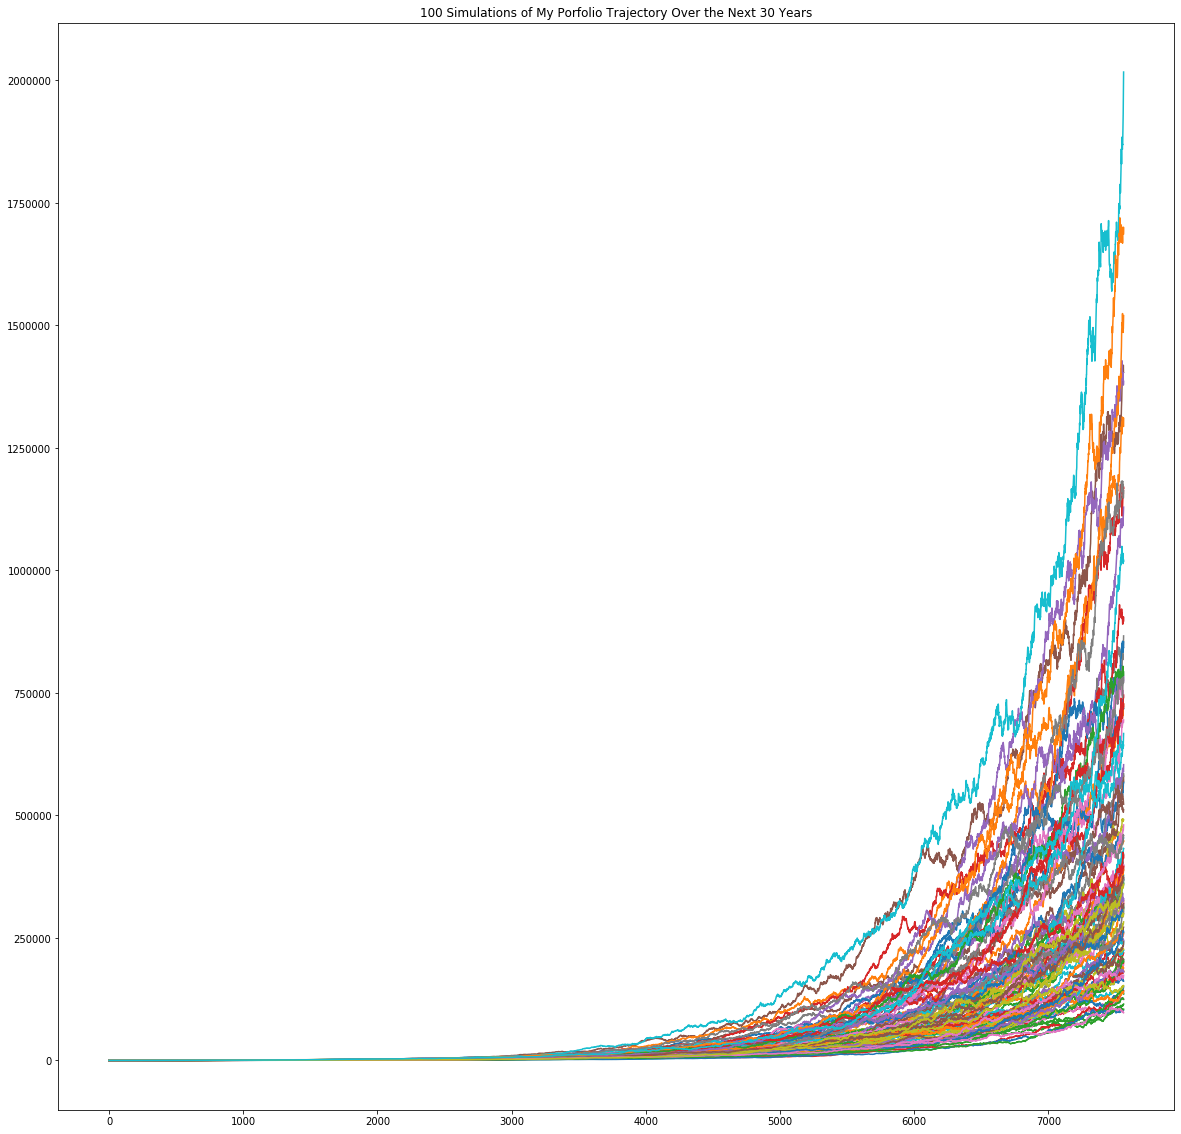

In [14]:
# Visualize the Simulation
plot_title = f"{number+1} Simulations of My Porfolio Trajectory Over the Next 30 Years"
monte_carlo.plot(legend=None, title=plot_title, figsize = (20,20))

In [15]:
# Select the last row for the cumulative returns (cumulative returns at 30 years)

simulated_ending_prices = monte_carlo.iloc[-1, :]

cum_returns = (simulated_ending_prices / monte_carlo.iloc[1, :])- 1
cum_returns

Simulation 1      1563.649084
Simulation 2      1365.231607
Simulation 3      1312.714638
Simulation 4       830.107826
Simulation 5      1284.691275
                     ...     
Simulation 96     1568.881857
Simulation 97      405.989821
Simulation 98     3206.470435
Simulation 99     1508.361389
Simulation 100    4257.793945
Length: 100, dtype: float64

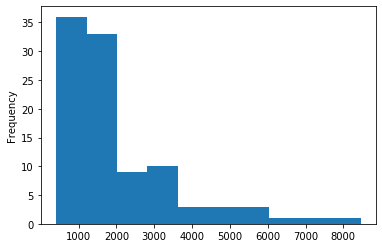

In [16]:
# Plot the last row for the cumulative returns (cumulative returns at 30 years)
cum_returns.plot(kind='hist')

In [17]:
# Display the 90% confidence interval for the ending returns
confidence_interval = cum_returns.quantile(q=[0.05, 0.95])
confidence_interval.iloc[0]

523.8357494900233

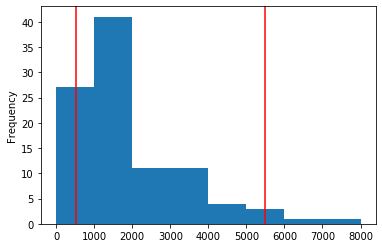

In [18]:
# Visualize the distribution of the ending returns

plt.figure();
cum_returns.plot(kind='hist', density=False, bins = [0,1000,2000,3000,4000,5000,6000,7000,8000])
plt.axvline(confidence_interval.iloc[0], color='r')
plt.axvline(confidence_interval.iloc[1], color='r')

---

## Retirement Analysis

In this section, you will use the monte carlo model to answer the following retirement planning questions:

1. What are the expected cumulative returns at `30` years for the `10th`, `50th`, and `90th` percentiles?

2. Given an initial investment of `$20,000`, what is the expected return in dollars at the `10th`, `50th`, and `90th` percentiles?

3. Given the current projected annual income from the Plaid analysis, will a `4%` withdrawal rate meet or exceed that value at the `10th` percentile? Note: This is basically determining if retirement income is equivalent to current income.

4. How would a `50%` increase in the initial investment amount affect the `4%` retirement withdrawal? In other words, what happens if the initial investment had been bigger?

### What are the expected cumulative returns at 30 years for the 10th, 50th, and 90th percentiles?

In [19]:
# Compute cumulative returns
retirement_confidence_interval = cum_returns.quantile(q=[0.1,.5, 0.9])
retirement_confidence_interval

0.1     624.676125
0.5    1511.621036
0.9    3835.211855
dtype: float64

### Given an initial investment of `$20,000`, what is the expected portfolio return in dollars at the 10th, 50th, and 90th percentiles?

In [20]:
# Set initial investment
initial_investment = 20000




# Compute expected portfolio return
portfolio_return_10th_percentile = initial_investment * retirement_confidence_interval.iloc[0]
portfolio_return_50th_percentile = initial_investment * retirement_confidence_interval.iloc[1]
portfolio_return_90th_percentile = initial_investment * retirement_confidence_interval.iloc[2]

formatted_return = "${:,.2f}".format(portfolio_return_10th_percentile)
formatted_return 

'$12,493,522.49'

### Given the current projected annual income from the Plaid analysis, will a 4% withdraw rate from the retirement portfolio meet or exceed that value at the 10th percentile?

Note: This is effectively saying that 90% of the expected returns will be greater than the return at the 10th percentile, so this can help measure the uncertainty about having enough funds at retirement

In [27]:
# Set Plaid's projected income
projected_income = 7389
adjusted_income = projected_income *((1.02)**30)

# Calculate the 4% withdrawal for the ending return as retirement income
retirement_income = portfolio_return_10th_percentile * 0.04

# Determine if the retirement income meets or exceeds the current projected income
print(f'{retirement_income} is the 4% withdrawal at 10th percentile')
print(f'{adjusted_income} is the expected inflation adjusted income at retirement')

499740.8997408876 is the 4% withdrawal at 10th percentile
13384.150744939689 is the inflation adjusted income at retirement


### How would a 50% increase in the initial investment amount affect the 4% retirement withdrawal?

In [22]:
# Re-calculate the retirement income with a 50% increase in the initial investment amount


### Optional Challenge

Use the Monte Carlo data and calculate the cumulative returns at the `5%`, `50%`, and `95%` quartiles and plot this data as a line chart to see how the cumulative returns change over the life of the investment.

In this section, you need to calculate and plot the cumulative returns for the median and `90%` confidence intervals. This plot shows the expected cumulative returns for any given day between the first day and the last day of investment. 

In [23]:
# Compute projected returns

# Display sample data


In [24]:
# Plot the cumulative returns over time


In [25]:
# Compute portfolio performance over time

# Plot projected performance over time
